# Final Project - LES Precipitation Forecasting

by Dhanush Kumar, Shubham Goyal (Group 6) <div>

## Contents 
- Introduction
- Data Preparation
    - Data Used :
        - Satelite Images of Cloud Cover
        - Meteorological Data
    - Processing :
        - Redundant Variables Drop 
        - Missing Values
        - Slicing of Images into 8hr buckets
        - Slicing of Meteo Data into 24 hr buckets
        - Creating a sliding window Precipitation (Target Label)
        - Min-Max Scaling
- Modeling:
    - Encoder-Decoder Architecture (ConvLSTM + LSTM)
    - Predictions
    - Performance Confusion Matrix
    - Prediction Examples
- Approaches that didn't work :(
- Conclusion

## 1) Introduction

In this project we need to create an amalgamation of CNN & RNN models to accurately forecast precipitaion of snow/rain at Lake michigan. We have ~16K satelite images of lake michigan with frequent cloud cover and subsequent weather forecast specific variables with data at hour level <div>

We started with first creating a mapping between the images and the weather forecast data and then figured out how to structure our data to model forecating. It's important to note given it's forecasting we will also not have images for the following days to predict the precipitation, hence we have to create a sliding window based data and then train our models on it <div>

When we created the mapping, we observed that it is not necessary that there is clear match with precipitation and cloud image, but it would be sequence of images representing the flow of clouds over Lake Michigan which would indicate if it rains or not <div>

This was a critical finding and with Professor's hint on using `ConvLSTM` for the sequence of images, we were able to connect the dots. We then worked on to create classic Encoder-Decoder style architecture to use `ConvLSTM` for extracting feature from sequence of images, and `LSTM` for the time series Meteorological <div>

Lastly, we treat this problem as a `binary classification` where if the precipitation sum in a day is `>0.1` it means it rained else it did not. <div>

## 2) Data Preparation

### Importing Libraries

In [1]:
import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model, load_model
from keras.layers import Input, LSTM, ConvLSTM2D, Dense, Add, Dropout, Flatten, Reshape
from keras.layers import TimeDistributed, BatchNormalization
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Importing Satelite Images of Lake Michigan

These are preprocessed images specifically focused on cloud cover on lake michigan ~16K in total

In [2]:
images = []
for idx in tqdm(range(15959)):
    im = cv2.imread('/kaggle/input/images/lake-michigan-64-2006-2017/lake-michigan-images-64/' + str(idx) + '.png')
    # Storing 1 channel, since the images are grayscale, and cropping
    images.append(im[8:-8,8:-8,0]) 
    # images shape -> (35, 64, 64) 

100%|██████████| 15959/15959 [01:30<00:00, 177.24it/s]


### Reading the Meteorological data

LES Meteorological data consists of many features with the target variable of Precipitation starting from 2006 to 2017. We would focus on relevant 10 features like Temperature, Dew point etc and create a smaller subset

In [3]:
les = pd.read_csv(r"/kaggle/input/finals/2006Fall_2017Spring_GOES_meteo_combined.csv")

In [4]:
# Renaming
les.rename(columns={ "Temp (F)": "Temp_F", "RH (%)": "RH_pct",
                   "Dewpt (F)" : "Dewpt_F", "Wind Spd (mph)" : "Wind_Spd_mph",
                   "Wind Direction (deg)" : "Wind_Direction_deg", "Peak Wind Gust(mph)" : "Peak_Wind_Gust_mph",
                   "Low Cloud Ht (ft)" : "Low_Cloud_Ht_ft", "Med Cloud Ht (ft)" : "Med_Cloud_Ht_ft",
                   "High Cloud Ht (ft)" : "High_Cloud_Ht_ft", "Visibility (mi)" : "Visibility_mi",
                   "Atm Press (hPa)" : "Atm_Press_hPa", "Sea Lev Press (hPa)" : "Sea_Lev_Press_hPa",
                   "Altimeter (hPa)" : "Altimeter_hPa", "Precip (in)" : "Precip_in",
                   "Wind Chill (F)" : "Wind_Chill_F", "Heat Index (F)" : "Heat_Index_F",
                   } , inplace = True)

les.head()

,Date_UTC,Time_UTC,Date_CST,Time_CST,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp_F,RH_pct,...,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in,Wind_Chill_F,Heat_Index_F
0,2006-10-01,00:00,2006-09-30,00:00,goes11.2006.10.01.0000.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv,"[0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...","[array([ nan, nan, nan, nan, nan...",48,86,...,4100,4800,7000,10,984.0,1007.00,1006.80,0.00,45,NC
1,2006-10-01,01:00,2006-09-30,01:00,goes11.2006.10.01.0100.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...","[array([ nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,983.7,1006.50,1006.40,0.00,44,NC
2,2006-10-01,02:00,2006-09-30,02:00,goes11.2006.10.01.0200.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv,"[0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,5500,11000,m,10,982.7,1005.70,1005.40,0.00,45,NC
3,2006-10-01,03:00,2006-09-30,03:00,goes11.2006.10.01.0300.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,982.0,1005.10,1004.70,0.00,44,NC
4,2006-10-01,04:00,2006-09-30,04:00,goes11.2006.10.01.0400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...","[array([ nan, nan, nan, nan, nan...",48,89,...,2200,3500,m,8,982.0,1004.90,1004.70,0.02,46,NC


The original dataset begins at 00:00 UTC, extends to 23:00, and then returns to 00:00 of the next day.

Central Standard Time (North America) typically lags 6 hours behind UTC. However, Traverse City, Michigan operates on GMT/UTC - 5 hours during Standard Time and GMT/UTC - 4 hours during Daylight Saving Time

Replacing missing values with 0 and dropping the columns WindChill and Heat Index

In [5]:
les = les.replace(['m', 'M'], '0')
les = les.drop(['Wind_Chill_F', 'Heat_Index_F'], axis=1)
les = les.reset_index(drop=True)
les = les.dropna(subset = ['Temp_F'])


In [6]:
les.columns

Index(['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake',
       'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Temp_F',
       'RH_pct', 'Dewpt_F', 'Wind_Spd_mph', 'Wind_Direction_deg',
       'Peak_Wind_Gust_mph', 'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
       'High_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa',
       'Sea_Lev_Press_hPa', 'Altimeter_hPa', 'Precip_in'],
      dtype='object')

### Dropping highly correlated features

Some highly correlated and redundant features are removed from the dataset. These include 'Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Dewpt_F', 'Peak_Wind_Gust_mph', and potentially 'Altimeter_hPa', due to its high correlation with 'Atm_Press_hPa'

In [7]:
les.columns

Index(['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake',
       'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Temp_F',
       'RH_pct', 'Dewpt_F', 'Wind_Spd_mph', 'Wind_Direction_deg',
       'Peak_Wind_Gust_mph', 'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
       'High_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa',
       'Sea_Lev_Press_hPa', 'Altimeter_hPa', 'Precip_in'],
      dtype='object')

In [8]:
meteo_les = les.drop(
    [ 'Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake', 
     'Lake_data_1D', 'Lake_data_2D', 'Dewpt_F', 'Peak_Wind_Gust_mph', 'Altimeter_hPa' ], axis=1)

In [9]:
meteo_les.head()

,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Precip_in
0,48,86,7,150,4100,4800,7000,10,984.0,1007.00,0.00
1,48,86,8,150,6000,0,0,10,983.7,1006.50,0.00
2,48,86,6,0,5500,11000,0,10,982.7,1005.70,0.00
3,48,86,8,150,6000,0,0,10,982.0,1005.10,0.00
4,48,89,5,0,2200,3500,0,8,982.0,1004.90,0.02


In [10]:
len(meteo_les)

47882

### Creating Slices of 24hr with Meteo data

We create slices with 24 hours of data to represent daily observations

In [11]:
x3 = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[0:30000], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=30000)

In [12]:
for batch in x3:
    print(batch.shape)
    print('--')

(1250, 24, 11)
--


The dataset comprises 1,995 observations of 24-hour meteorological data, each containing 11 features. For training and validation split we would use initial 30000 data points for `Train` and rest for `Validation` data

In [13]:
meteo_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[0:30000], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=30000)

In [14]:
meteo_train_batched

<_BatchDataset element_spec=TensorSpec(shape=(None, None, 11), dtype=tf.string, name=None)>

In [15]:
def convert_byte_tensor_to_float(tensor):
    string_tensor = tf.strings.regex_replace(tensor, '^b\'(.*)\'$', '\\1')
    float_tensor = tf.strings.to_number(string_tensor, out_type=tf.float32)
    return float_tensor

In [16]:
meteo_train = None
for batch in meteo_train_batched:
    meteo_train = batch
    print(meteo_train.shape)
    print('--')

(1250, 24, 11)
--


In [17]:
print(meteo_train[0])

tf.Tensor(
[[b'48' b'86' b'7' b'150' b'4100' b'4800' b'7000' b'10' b'984.0'
  b'1007.00' b'0.00']
 [b'48' b'86' b'8' b'150' b'6000' b'0' b'0' b'10' b'983.7' b'1006.50'
  b'0.00']
 [b'48' b'86' b'6' b'0' b'5500' b'11000' b'0' b'10' b'982.7' b'1005.70'
  b'0.00']
 [b'48' b'86' b'8' b'150' b'6000' b'0' b'0' b'10' b'982.0' b'1005.10'
  b'0.00']
 [b'48' b'89' b'5' b'0' b'2200' b'3500' b'0' b'8' b'982.0' b'1004.90'
  b'0.02']
 [b'48' b'89' b'6' b'0' b'2700' b'5500' b'7500' b'10' b'981.7' b'1004.60'
  b'0.01']
 [b'42' b'95' b'0' b'0' b'4600' b'0' b'0' b'8' b'991.7' b'1014.80'
  b'0.00']
 [b'43' b'96' b'0' b'0' b'3900' b'0' b'0' b'10' b'992.3' b'1015.60'
  b'0.00']
 [b'48' b'92' b'0' b'0' b'3600' b'0' b'0' b'10' b'993.0' b'1016.30'
  b'0.00']
 [b'55' b'59' b'11' b'300' b'3600' b'0' b'0' b'10' b'993.7' b'1016.90'
  b'0.00']
 [b'55' b'61' b'10' b'300' b'3600' b'0' b'0' b'10' b'994.3' b'1017.50'
  b'0.00']
 [b'58' b'55' b'8' b'290' b'3600' b'0' b'0' b'10' b'995.0' b'1018.00'
  b'0.00']
 [b'56' b'

Removing the byte representation from the data

In [18]:
meteo_train = tf.map_fn(
    lambda batch: tf.map_fn(
        lambda sample: convert_byte_tensor_to_float(sample),
        batch,
        dtype=tf.float32),
    meteo_train,
    dtype=tf.float32)

In [19]:
meteo_train.shape

TensorShape([1250, 24, 11])

Summing the precipitation values for each hour of the day 

In [20]:
rain_train = []

for sample in meteo_train:
    last_column = sample[:, -1]

    # Sum the values in the last column
    rain_sum = tf.reduce_sum(last_column)

    # Append the sum to rain_train
    rain_train.append(rain_sum)

rain_train = tf.stack(rain_train)

In [21]:
# if > 0.10 inches of rain, then rain = 1, else rain = 0
rain_train_b = tf.where(rain_train > 0.10, 1, 0)

In [22]:
len(rain_train_b)

1250

As we can observe below, there are only 190 days, where it rains which makes the data highly imbalanced. We'll be treating the imabalance going forward, with class-weights during our training

In [23]:
pd.Series(rain_train_b.numpy()).value_counts()

0    1060
1     190
Name: count, dtype: int64

Dropping the precipitation column from the meteo training data

In [24]:
meteo_train = meteo_train[:, :, :-1]
print(meteo_train.shape)

(1250, 24, 10)


### Min-Max Scaling

Scaling is an important step to create a scaled data as it avoids any unnecessary spkies in the data and ensures better training for the model

In [25]:

scaler = MinMaxScaler()

n_samples, n_timesteps, n_features = meteo_train.shape
meteo_train= tf.reshape(meteo_train, [n_samples * n_timesteps, n_features])
meteo_train = meteo_train.numpy()
meteo_train = scaler.fit_transform(meteo_train)
meteo_train = tf.reshape(meteo_train, [n_samples, n_timesteps, n_features]).numpy()

In [26]:
meteo_train.shape

(1250, 24, 10)

The validation dataset for imagery begins at index 13,050, with a total of 15,959 instances of imagery recorded. The last 2,500 instances of imagery are designated as the validation dataset, excluding some intermediate 'nan' instances. This corresponds to 7,500 rows of meteorological data

In [27]:
meteo_val_batched = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[:7500], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=7500)

In [28]:
meteo_val = None
for batch in meteo_val_batched:
    meteo_val = batch
    print(meteo_val.shape)
    print('--')

(312, 24, 11)
--


In [29]:
meteo_val = tf.map_fn(
    lambda batch: tf.map_fn(
        lambda sample: convert_byte_tensor_to_float(sample),
        batch,
        dtype=tf.float32),
    meteo_val,
    dtype=tf.float32)

In [30]:
rain_val= []

for sample in meteo_val:
    last_column = sample[:, -1]

    rain_sum = tf.reduce_sum(last_column)

    rain_val.append(rain_sum)

rain_val = tf.stack(rain_val)

In [31]:
# if > 0.10 inches of rain, then rain = 1, else rain = 0
rain_val_b = tf.where(rain_val > 0.10, 1, 0)

In [32]:
rain_val_b

<tf.Tensor: shape=(312,), dtype=int32, numpy=
array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

In [33]:
meteo_val = meteo_val[:, :, :-1]

Scaling Validation data based on the train values

In [34]:
n_samples_val, n_timesteps_val, n_features_val = meteo_val.shape
meteo_val = tf.reshape(meteo_val, [n_samples_val * n_timesteps_val, n_features_val])
meteo_val = meteo_val.numpy()
meteo_val = scaler.transform(meteo_val)
meteo_val = tf.reshape(meteo_val, [n_samples_val, n_timesteps_val, n_features_val]).numpy()


In [35]:
meteo_val.shape

(312, 24, 10)

So we have about 3 times more training data than test data.

### Creating Image data 8hr window slices 

Our training dataset will consist of 8 hour sequence of images and the label will be rain or not for *the next day* (Sliding window 1-day shift)


In [36]:
cloud_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(images[:10000], None, 8, sequence_stride=8, 
                                                                           sampling_rate=1, batch_size=10000)

In [37]:
cloud_train = None
for batch in cloud_train_batched:
    cloud_train = batch
    cloud_train = np.expand_dims(cloud_train, axis=-1)
    print(cloud_train.shape)
    cloud_train = cloud_train / 255
    print('--')

(1250, 8, 48, 48, 1)
--


For Validation set we take the last 2500 values

In [38]:
cloud_val_batched = tf.keras.preprocessing.timeseries_dataset_from_array(images[:2500], None, 8, sequence_stride=8, 
                                                                         sampling_rate=1, batch_size=2500)

In [39]:
cloud_val = None
for batch in cloud_val_batched:
    cloud_val = batch
    cloud_val = np.expand_dims(cloud_val, axis=-1)
    print(cloud_val.shape)
    cloud_val = cloud_val / 255
    print('--')

(312, 8, 48, 48, 1)
--


### Creating the ytrain values by shifting one day ahead for 24 hour prediction

In [40]:
# Assign rain train c as array from rain train b
rain_train_c = rain_train_b.numpy()

In [41]:
rain_val_c = rain_val_b.numpy()

Shifting by 1 day here, going forward we'll have to drop the last low from each set, as it wouldn't have a y label

In [42]:
rain_train_c_mod = [rain_train_c[x+1] for x in range(len(rain_train_c)-1)]
len(rain_train_c_mod)

1249

In [43]:
rain_val_c_mod = [rain_val_c[x+1] for x in range(len(rain_val_c)-1)]

Checking the shift

In [44]:
print(rain_train_c[0:10], rain_train_c_mod[0:10])

[0 0 1 0 1 0 0 0 0 0] [0, 1, 0, 1, 0, 0, 0, 0, 0, 1]


In [45]:
cloud_train.shape, rain_train_c.shape, cloud_val.shape, rain_val_c.shape

((1250, 8, 48, 48, 1), (1250,), (312, 8, 48, 48, 1), (312,))

## 3) Modeling

### Encoder Decoder ConvLSTM + LSTM

As we dicussed earlier we follow a classic Encoder-Decoder structure where we have ConvLSTM for images feature extraction along with LSTM for Meteorological time-series data, which we combine and feed to decoder layer where an LSTM exists and generates output forecast 

Dropping the last data point from the train data and validation data as the last row wouldn't have any available forecast

In [46]:
# Drop the last value from each of the training datasets
meteo_train = meteo_train[:-1]
cloud_train = cloud_train[:-1]

# Drop the last value from each of the validation datasets
meteo_val = meteo_val[:-1]
cloud_val = cloud_val[:-1]

In [47]:
meteo_train = np.asarray(meteo_train)
cloud_train = np.asarray(cloud_train)
rain_train_c_mod = np.asarray(rain_train_c_mod)

meteo_val = np.asarray(meteo_val)
cloud_val = np.asarray(cloud_val)
rain_val_c_mod = np.asarray(rain_val_c_mod)

In [48]:
print(meteo_train.shape, cloud_train.shape, rain_train_c_mod.shape, meteo_val.shape, cloud_val.shape, rain_val_c_mod.shape)

(1249, 24, 10) (1249, 8, 48, 48, 1) (1249,) (311, 24, 10) (311, 8, 48, 48, 1) (311,)


This model employs LSTM layers to process sequential meteorological data and ConvLSTM2D layers for spatial-temporal cloud imagery, integrating both data streams using an **addition operation**.  This adding of encoder lstm and convlstm output is a new approach which we  tried. The merged features are then decoded through additional LSTM layers and regularized with dropout and finally passed through a dense layer to predict the precipitation.

In [57]:
# Specifying the input shapes
meteo_input = Input(shape=(24, 10))
cloud_input = Input(shape=(8, 48, 48, 1))

## Encoder Layers 

# Starting with LSTM for Meteorological Data 
lstm_encoder = LSTM(128, return_sequences=True)(meteo_input)
lstm_encoder = Dropout(0.3)(lstm_encoder)
lstm_encoder = LSTM(64, return_sequences=True)(lstm_encoder)
lstm_encoder = Dropout(0.3)(lstm_encoder)
lstm_encoder = LSTM(64, return_sequences=False)(lstm_encoder)
lstm_encoder = BatchNormalization()(lstm_encoder)

# Followed by ConvLSTM for Cloud Data
convlstm_1 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True)(cloud_input)
convlstm_1 = Dropout(0.3)(convlstm_1)
convlstm_2 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(convlstm_1)
convlstm_2 = Dropout(0.3)(convlstm_2)
convlstm_3 = ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=True)(convlstm_2) 
flattened = TimeDistributed(Flatten())(convlstm_3)
convlstm_output = LSTM(64, return_sequences=False)(flattened)  # Keep 64 units
convlstm_output = BatchNormalization()(convlstm_output)

# Combining the outputs of the LSTM and ConvLSTM layers
combined_features = Add()([lstm_encoder, convlstm_output])

# Decoder Layers
decoder_1 = LSTM(128, return_sequences=True)(Reshape((1, 64))(combined_features))
decoder_1 = Dropout(0.3)(decoder_1)
decoder_2 = LSTM(64, return_sequences=False)(decoder_1)
decoder_2 = Dropout(0.3)(decoder_2)
output = Dense(1, activation='sigmoid')(decoder_2)

model_lstm_ml = Model(inputs=[meteo_input, cloud_input], outputs=output)

new_learning_rate = 0.0001
optimizer = Adam(learning_rate=new_learning_rate)

model_lstm_ml.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_lstm_ml.summary()


Model: "model"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_2 (InputLayer)           [(None, 8, 48, 48,   0           []                               

                                1)]                                                               

                                                                                                  

 conv_lstm2d (ConvLSTM2D)       (None, 8, 48, 48, 3  38144       ['input_2[0][0]']                

                                2)                                                                

                                                                                                  

 input_1 (InputLayer)           [(None, 24, 10)]     0           []                               

                                                                                   

### Class-Weights and Training
Adding **class weights** to the data 80% for class 1 and 20% for class 0 to handle the imapct of class imbalance, we chose 80% to counter-allocate the class imabalance of the labels

In [58]:
# Define the desired weight for class 1 (rain)
desired_weight_class1 = 0.80

# Calculate the weight for class 0 (not rain)
weight_class0 = 1 - desired_weight_class1

# Create the class weight dictionary
class_weight_dict = {0: weight_class0, 1: desired_weight_class1}



history = model_lstm_ml.fit(
    [meteo_train, cloud_train],
    rain_train_c_mod,
    epochs=50,
    batch_size=10,
    validation_data=([meteo_val, cloud_val], rain_val_c_mod),
    class_weight=class_weight_dict)



Epoch 1/50

125/125 [==============================] - 153s 959ms/step - loss: 0.1990 - accuracy: 0.6189 - val_loss: 0.6781 - val_accuracy: 0.7588

Epoch 2/50

125/125 [==============================] - 133s 1s/step - loss: 0.1959 - accuracy: 0.6069 - val_loss: 0.6730 - val_accuracy: 0.7492

Epoch 3/50

125/125 [==============================] - 159s 1s/step - loss: 0.1892 - accuracy: 0.6069 - val_loss: 0.6945 - val_accuracy: 0.4952

Epoch 4/50

125/125 [==============================] - 174s 1s/step - loss: 0.1853 - accuracy: 0.5965 - val_loss: 0.6304 - val_accuracy: 0.6109

Epoch 5/50

125/125 [==============================] - 176s 1s/step - loss: 0.1817 - accuracy: 0.6461 - val_loss: 0.4258 - val_accuracy: 0.8199

Epoch 6/50

125/125 [==============================] - 158s 1s/step - loss: 0.1811 - accuracy: 0.6469 - val_loss: 0.7260 - val_accuracy: 0.3891

Epoch 7/50

125/125 [==============================] - 153s 1s/step - loss: 0.1826 - accuracy: 0.6405 - val_loss: 0.4408 - val_

The model works really well, and the loss starts to drop from `32nd epoch`, We eventually achieve a val accuracy of **89%** and given it's weighted it would represent the true accuracy adjusting to class imbalance

In [59]:
model_lstm_ml.save('24_deep_model.h5')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [61]:
predictions = model_lstm_ml.predict([meteo_val, cloud_val])

predicted_labels = (predictions > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(rain_val_c_mod, predicted_labels))

10/10 [==============================] - 6s 452ms/step

              precision    recall  f1-score   support



           0       0.97      0.90      0.93       263

           1       0.60      0.85      0.71        48



    accuracy                           0.89       311

   macro avg       0.79      0.88      0.82       311

weighted avg       0.91      0.89      0.90       311




We're able to achieve F1-score of 0.71, with a recall value of 0.85 which we believe represents a good training for the model

In [ ]:
pred_df = pd.DataFrame([predicted_labels.flatten(), rain_val_c_mod]).T
pred_df.columns = ['predicted', 'actual']
pred_df["Predictions_correct"] = pred_df["predicted"] == pred_df["actual"]

In [70]:
pred_df[pred_df['actual'] == 0].value_counts()

predicted  actual  Predictions_correct
0          0       True                   236
1          0       False                   27
Name: count, dtype: int64

In [71]:
pred_df[pred_df['actual'] == 1].value_counts()

predicted  actual  Predictions_correct
1          1       True                   41
0          1       False                   7
Name: count, dtype: int64

### Plotting the images for reference

Working example for class 1

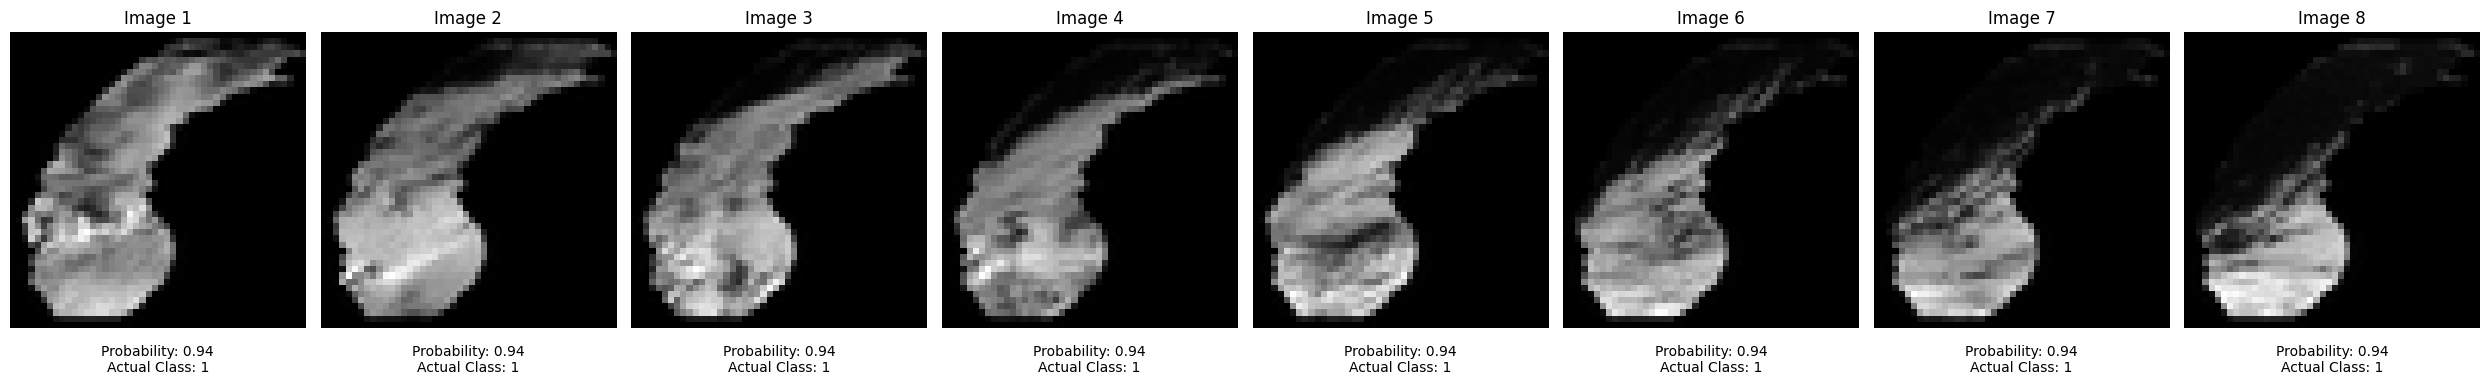

In [62]:


num_images = len(cloud_val[0]) #no of images in a single batch

fig, axes = plt.subplots(1, num_images, figsize=(25, 5))

for i, ax in enumerate(axes):
    # Display the image
    ax.imshow(cloud_val[3][i][:, :, 0], cmap='gray')  
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')  # Turn off axis
    
    # Extract the predicted probability and actual class for the i-th image
    probability = predictions[3][0]  
    actual_class = rain_val_c_mod[3]  
    
    ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
            transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()


Our model predicts rain for the next day with a 94% probability, and matches with the actual label of 1

Working Example for Class 0

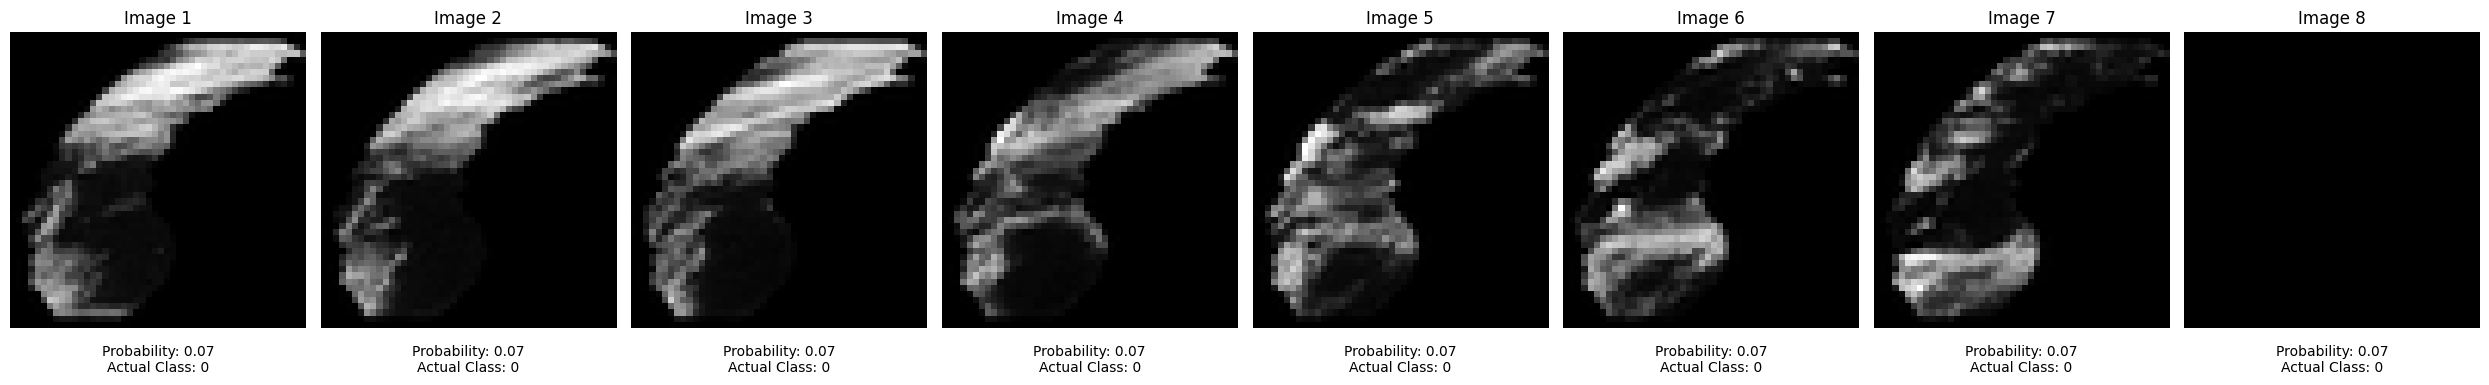

In [63]:

num_images = len(cloud_val[0]) #no of images in a single batch

fig, axes = plt.subplots(1, num_images, figsize=(25, 5))

for i, ax in enumerate(axes):
    # Display the image
    ax.imshow(cloud_val[4][i][:, :, 0], cmap='gray')  
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')  # Turn off axis
    
    probability = predictions[4][0]  
    actual_class = rain_val_c_mod[4]  
    
    ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
            transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()


Looks intuitive, doesn't it? As we see the clouds dissappear, and our model forecasts no rain the next day which matches with the actual label as well

## Loading Trained model

In [49]:
model = load_model('/kaggle/input/les-model/24_deep_model.h5')

In [50]:
from sklearn.metrics import classification_report

predictions = model.predict([meteo_val, cloud_val])

predicted_labels = (predictions > 0.5).astype(int)

# print(classification_report(rain_val_c_mod, predicted_labels))

10/10 [==============================] - 10s 202ms/step


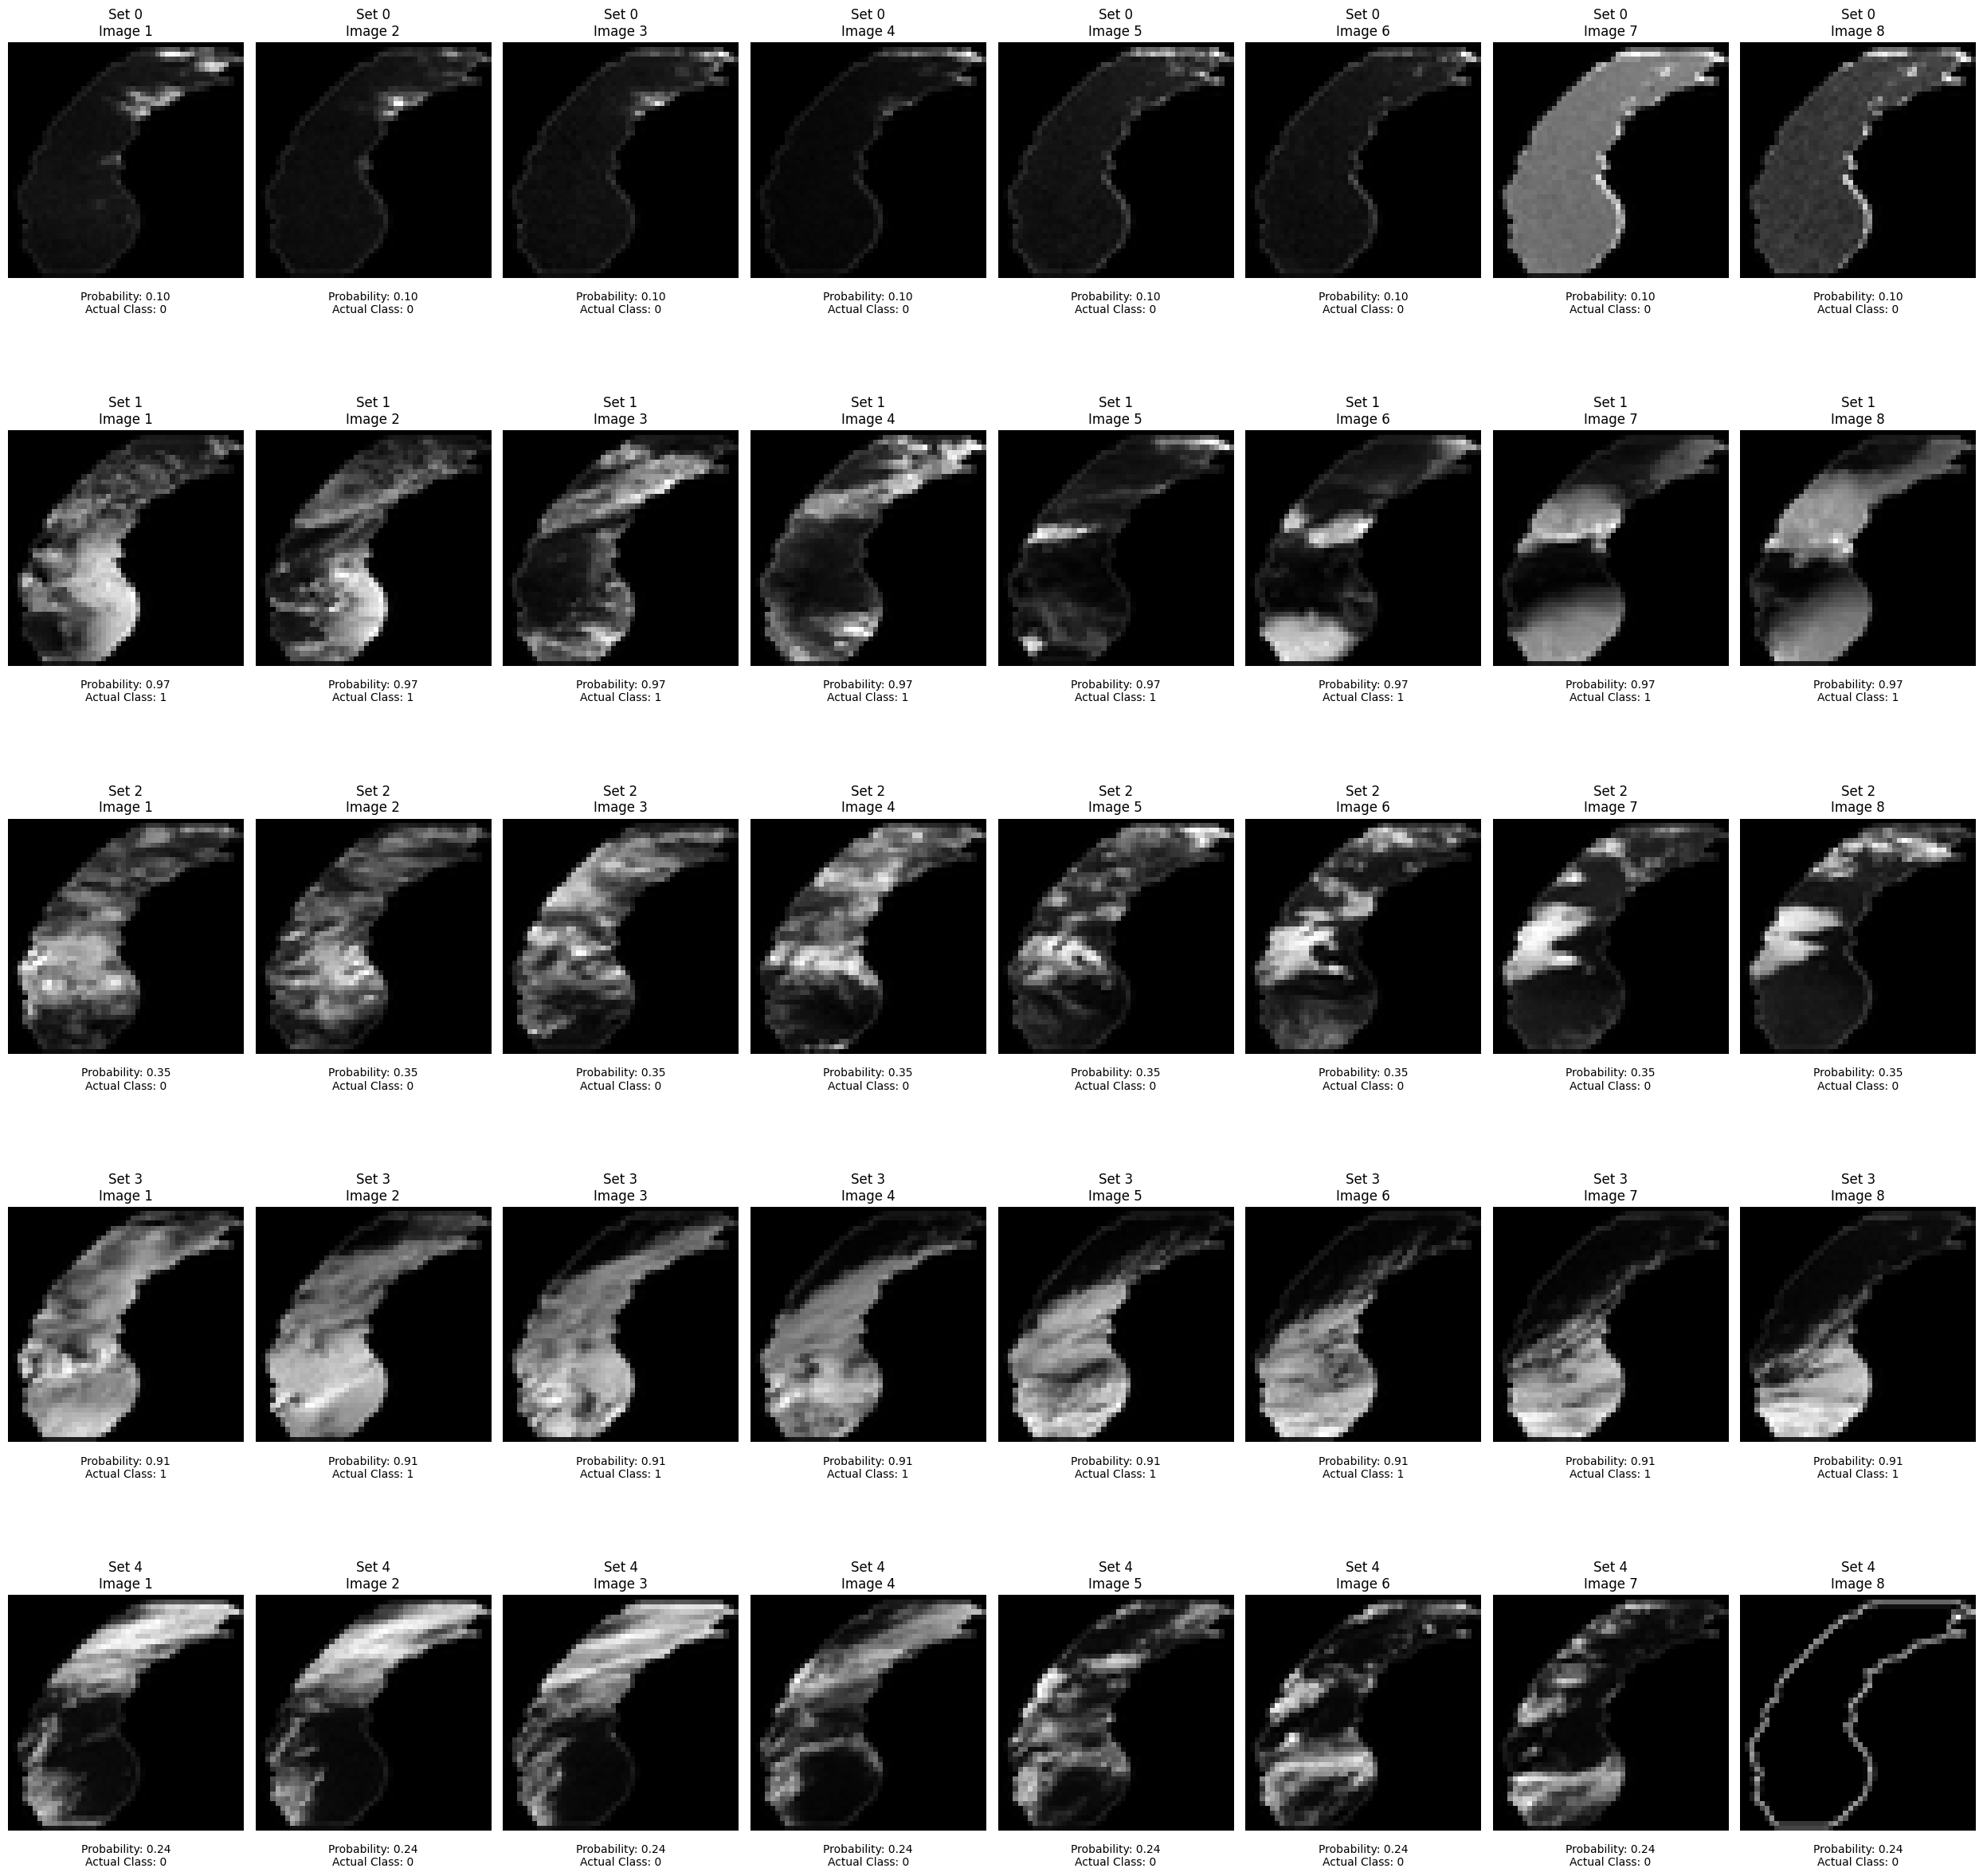

In [51]:
num_sets = 5  
num_images_per_set = 8 

fig, axes = plt.subplots(num_sets, num_images_per_set, figsize=(25, 5 * num_sets))

for set_idx in range(num_sets):
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[set_idx, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()

## Checking Incorrect Predictions

In [63]:
flattened_predicted_labels = np.array([item for sublist in predicted_labels for item in sublist])

mismatch_indices = np.where(flattened_predicted_labels != rain_val_c_mod)[0]

print("Mismatched indices:", set(mismatch_indices))

Mismatched indices: {256, 5, 6, 265, 268, 272, 17, 18, 276, 22, 150, 151, 152, 26, 153, 30, 43, 44, 45, 46, 47, 48, 49, 50, 174, 176, 177, 181, 55, 59, 61, 192, 71, 72, 73, 74, 205, 81, 82, 209, 84, 215, 88, 89, 91, 92, 220, 221, 96, 224, 227, 100, 105, 235, 242, 243, 245, 250}


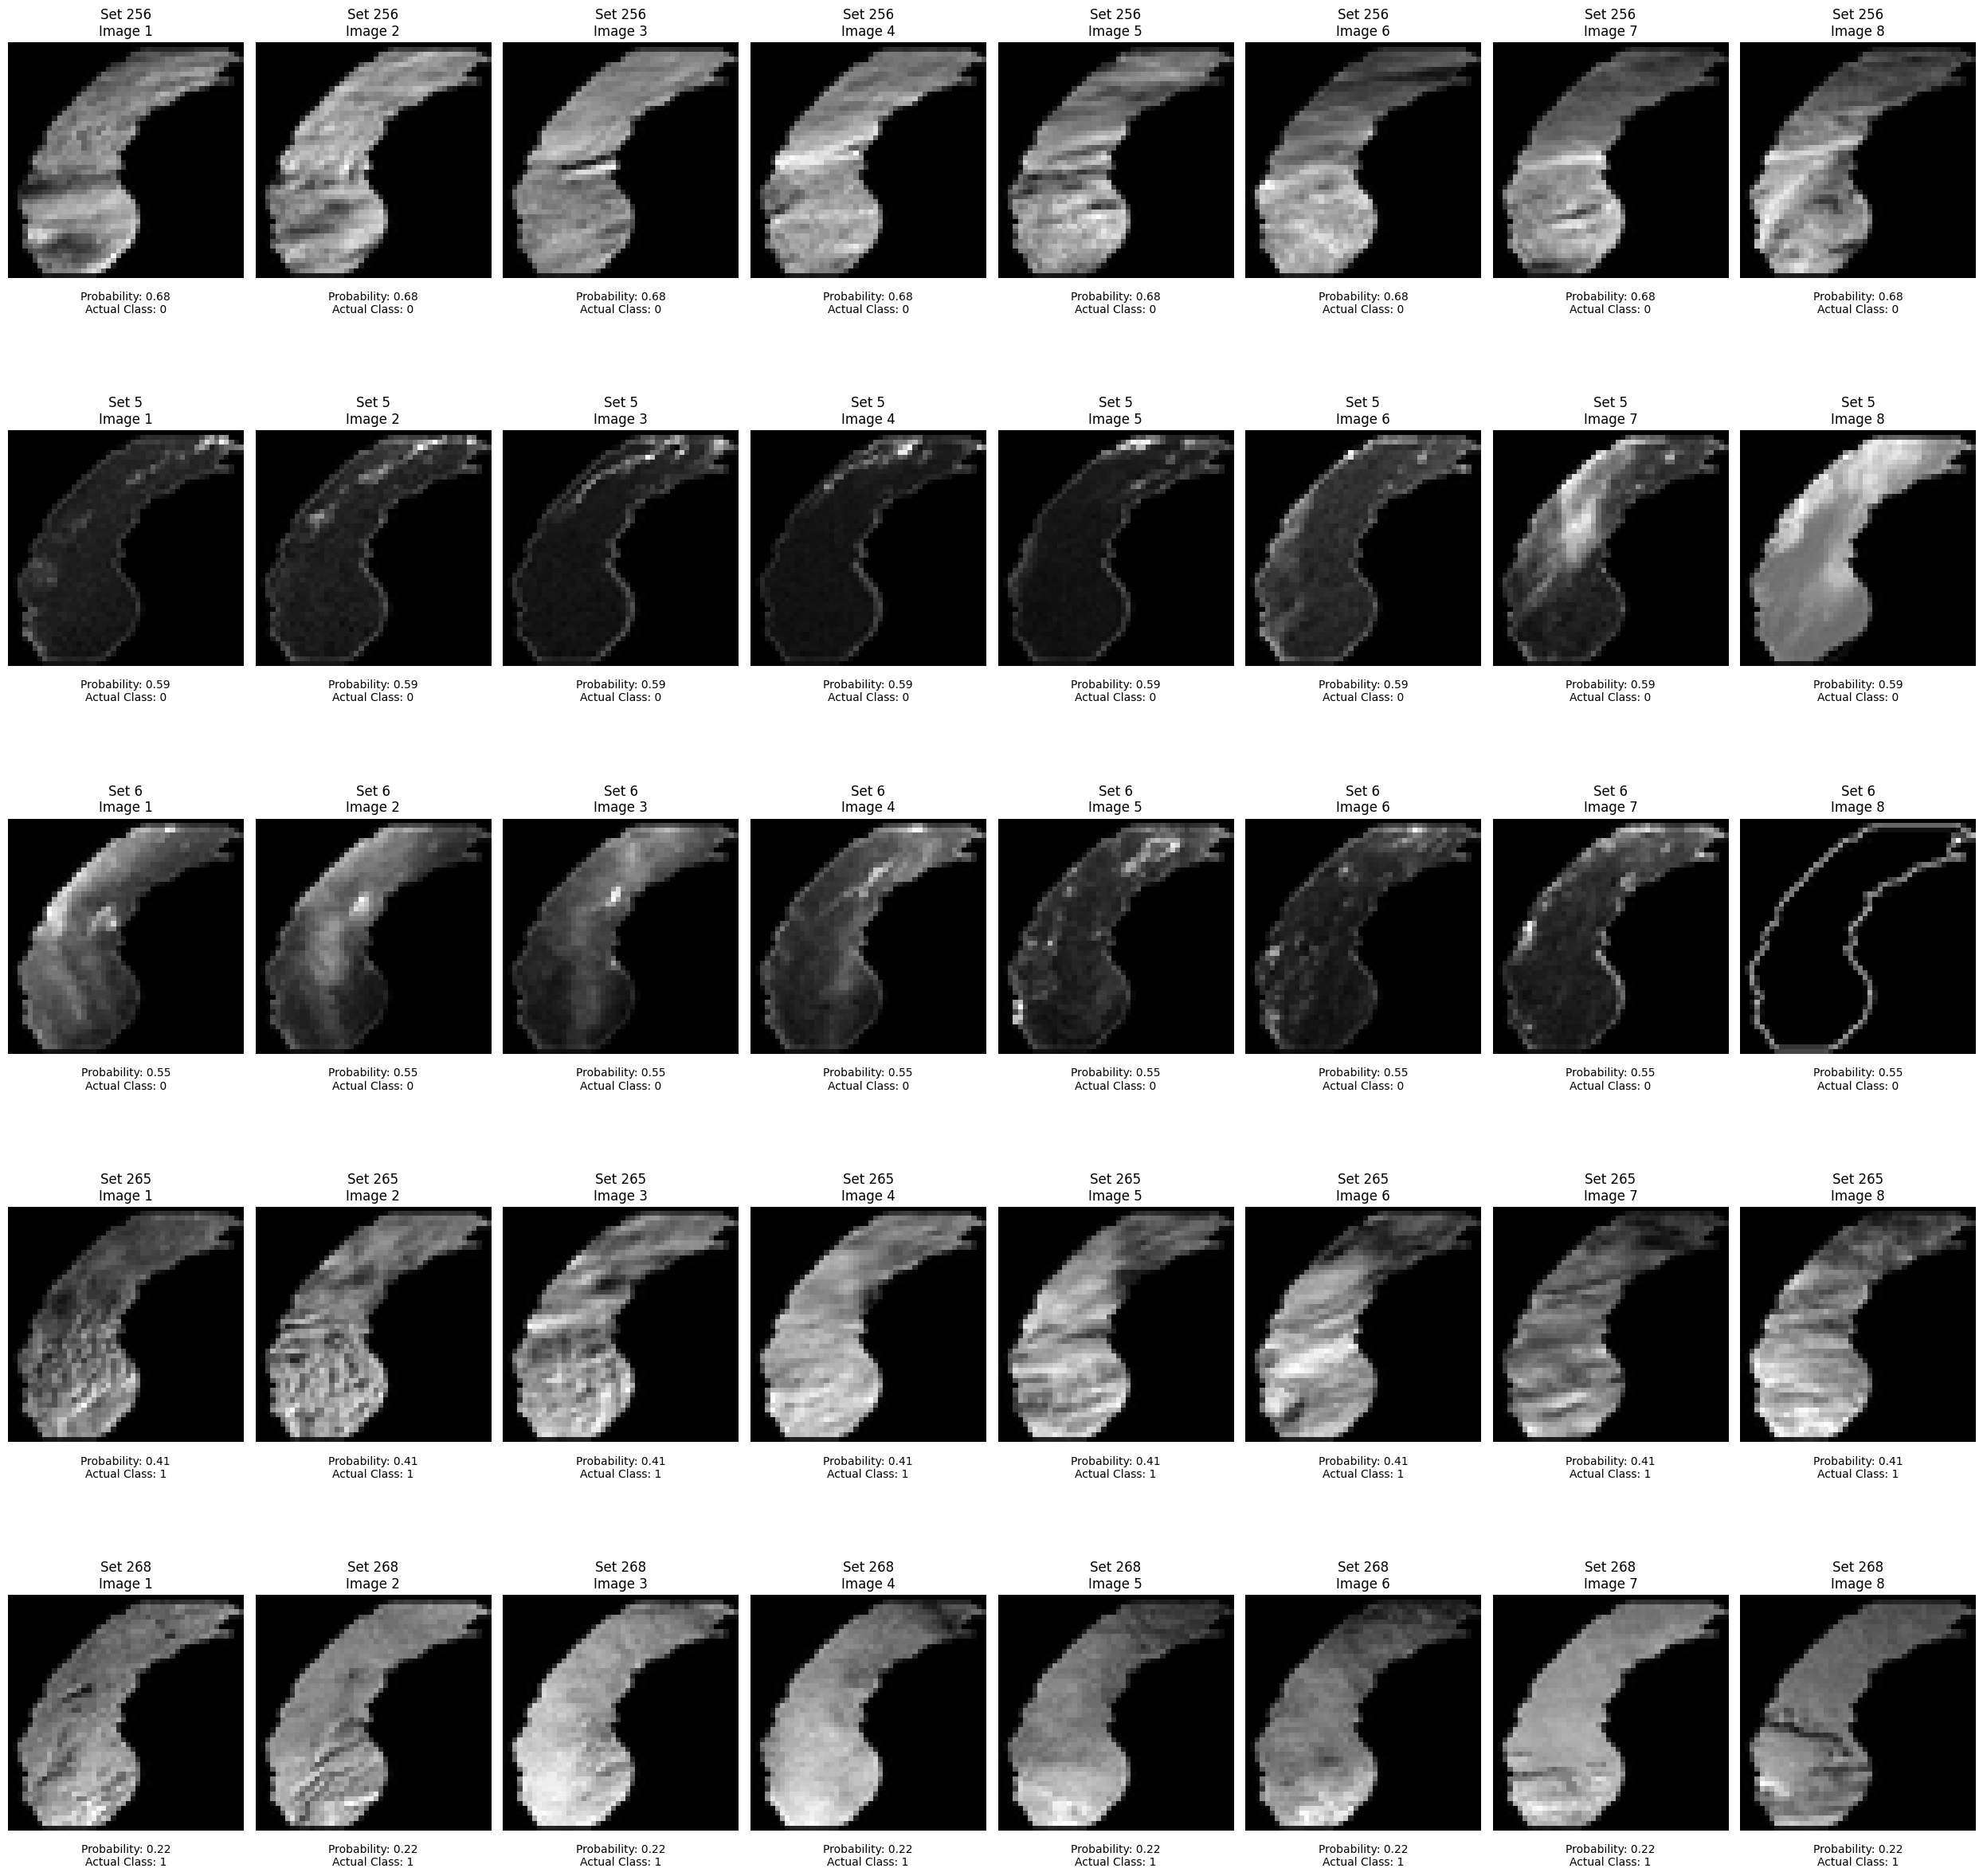

In [68]:
num_sets = [256, 5, 6, 265, 268] 
num_images_per_set = 8 

fig, axes = plt.subplots(5, num_images_per_set, figsize=(25, 5 * 5))
y=0
for set_idx in num_sets:
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[y, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')
    y+=1
plt.tight_layout()
plt.show()

### Approaches that didn't work

Some of the approaches that we tried but unfortunately did not work:
1. ConvLSTM2D for image data and LSTM for sequential data, merging them via concatenation before passing through dense layers - `Not great accuracy might be because of simple concatenation of ConvLSTM & LSTM outputs`
2. Encoder decoder based Transformer model with ConvLSTM - `Not able to implement fully, errors in training`
3. Using Self-Attention along with ConvLSTM - [Reference here](https://paperswithcode.com/paper/self-attention-convlstm-for-spatiotemporal) - `Plateaus at ~ 0.4 validation loss, and achieves 0.36 F1 score for Rain class`

### Conclusion

We conclude our project with a positive and optimistic note, we tried a lot of approaches, and eventually the approach with a much deeper model worked. Initially starting with lesser number of layer & of number of epochs didn't return a great accuracy for the same architecture, but as we saw it the loss drops after 32nd epoch which was a great learning for us too. Overall in this project we learned how we can work with sequential image data, and combine two different models to eventually create a Multi-Modal model.  



### Acknowledgement 

We would like to thank Professor Dino K. for his constant guidance and support, the problem was challenging enough for us to put our brains to work, and constantly search for new approaches to successfully achieve a better forecast. Specially with the `ConvLSTM` hint we were able to connect the dots and streamline our approach. Also thanks to our TA Pragnaya, for support throughout the semester. 

Thank You, and Happy Holidays!

